# Telecom Project - Decomposition
## Ron Sherwi

### Description of the data:
The datasets contain data on the use of the virtual telephony service CallMeMaybe. Its clients are organizations that need to distribute large numbers of incoming calls among various operators, or make outgoing calls through their operators. Operators can also make internal calls to communicate with one another. These calls go through CallMeMaybe's network.

### Goal:
Give supervisors information on the least effective operators.

### Specify details:
Identify operators that have:
- A large number of missed incoming calls (internal and external).
- A long waiting time for incoming calls. 
- A small number of attempts to make a call.

### Propose hypotheses:
- There may be correlation between share of missed incoming calls and long waiting time for incoming calls.
- There may be correlation between share of missed incoming calls and share of outgoing calls.
- There may be a significant difference between the average incoming calls waiting time of effective and ineffective operators.
- There may be a significant difference between the proportions of missed incoming calls of effective and ineffective operators.
- There may be a significant difference between the means of each plan.

### Mandatory stages of analysis:

- <u> <a href="#first_step"> Data preprocessing: </a> </u>
    - Study missing values
    - Study duplicate values
    - Check the correctness of column names
    - Rename the columns
    - Remove duplicates
    - Convert types
    - Replace missing values
- <u>  <a href="#second_step"> EDA: </a> </u>
    - Check distribution of calls & duration.
    - Find outliers - remove or correct.
    - Check correlations between the columns.
- <u> <a href="#third_step"> Define effective & ineffective operators: </a> </u>
    - Give a rank for each operator based on something like RFM analysis: 
        - Number of missed incoming calls
        - Waiting time for incoming calls
        - Number of outgoing calls
- <u> <a href="#fourth_step"> Test statistical hypotheses: </a> </u>
    - Difference between the average incoming calls waiting time of effective and ineffective operators.
    - Difference between the proportions of missed incoming calls of effective and ineffective operators. 
    - Difference between the average number of outgoing calls of effective and ineffective operators. 
    
## Link to Presentation <a href="https://drive.google.com/file/d/1S6UsYyt30D7H4Lwqzy_HsxKT_BzJdir_/view?usp=sharing"> Here </a>
## Link to Tableau dashboard  <a href="https://public.tableau.com/profile/ron.sherwi#!/vizhome/OperatorsBehavior/Dashboard?publish=yes"> Here </a>

#  <a id="first_step"> Stage 1 - Data Preprocessing </a> 

### Import libraries & files

In [2]:
# Basics & statistics
import pandas as pd
import numpy as np
import scipy.stats as st
import statistics 
import math
# Visualization
import matplotlib.pyplot as plt
!pip install --upgrade seaborn
import seaborn as sns

#Import files
path = r'/datasets/'
dataset_file = r'telecom_dataset_us.csv'
clients_file = r'telecom_clients_us.csv'
dataset = pd.read_csv(path + dataset_file, parse_dates=['date'])
clients = pd.read_csv(path + clients_file, parse_dates=['date_start'])

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 285 kB 1.2 MB/s eta 0:00:01


### Preprocessing 'dataset' 

In [3]:
dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null datetime64[ns, pytz.FixedOffset(180)]
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), datetime64[ns, pytz.FixedOffset(180)](1), float64(1), int64(4), object(2)
memory usage: 3.3+ MB


### Missing values

In [5]:
def missings(df):
    # Gets dataset.
    # Returns df that contains number of missing values & uniuqe values for each column.
    data = []
    for col in df.columns:
        missings = len(df[df[col].isnull()])
        values = len(df) - missings
        perc_missings = round(missings / len(df) * 100, 2)
        uniq = df[col].nunique()
        data.append([col, values, missings, perc_missings, uniq])
    df_missings = pd.DataFrame(data, columns = ['column', 'values', 'missings', 'perc_missisngs', 'uniq'])
    return df_missings

In [6]:
missings_df = missings(dataset)
missings_df

,column,values,missings,perc_missisngs,uniq
0,user_id,53902,0,0.00,307
1,date,53902,0,0.00,119
2,direction,53902,0,0.00,2
3,internal,53785,117,0.22,2
4,operator_id,45730,8172,15.16,1092
5,is_missed_call,53902,0,0.00,2
6,calls_count,53902,0,0.00,502
7,call_duration,53902,0,0.00,5373
8,total_call_duration,53902,0,0.00,6040


In [7]:
# Checking number of operators per user
dataset.groupby('user_id').agg({
    'operator_id': 'nunique', 'calls_count':'count'}).reset_index().rename(
    columns={'operator_id':'operators', 'calls_count':'trials'}).sort_values(by='operators', ascending=False).head()

,user_id,operators,trials
264,168187,50,2580
175,167626,48,1311
161,167497,30,1405
271,168252,28,929
248,168062,27,1182


In [8]:
# Checking proportion between internal / external calls per user

# Number of attemps to call per user
user_calls = dataset.groupby('user_id').agg({'calls_count': 'count'}).reset_index()

# Number of attemps to call per internal/external attemp
calls_type = dataset.pivot_table(
    index='user_id', columns='internal', values='calls_count', aggfunc='count').reset_index().fillna(0)
calls_type.columns = ['user_id', 'external', 'internal']
calls_type = calls_type.merge(user_calls, on='user_id', how='left') 
calls_type.head()

,user_id,external,internal,calls_count
0,166377,535.0,36.0,571
1,166391,14.0,6.0,20
2,166392,106.0,1.0,107
3,166399,23.0,0.0,23
4,166405,1017.0,23.0,1042


### Conclusions
1. <b> internal </b>
    - 0.2% are ampty. 
    - I checked the proportion between external and internal calls, and found that there are users with more than 100 external calls vs only 1 internal call. So it feels risky to change the values manually. 
    - <u> I decided to drop them out. </u>
    
2. <b> operator_id </b>. 
    - 15.15 % of total rows are empty 
    - I checked if every user has only one operator (and then we can fill the empties) but it's not the case.
    - <u> I decided to mark this operators as another operator, and continue analyzing. If i'll see that it's makes me struggle with investigation i'll drop them out. </u> 


In [9]:
# Mark empty operators
dataset.loc[dataset['operator_id'].isnull(), 'operator_id'] = 1

In [10]:
# Drop missing internal values
dataset = dataset.dropna()

### Convert types

In [11]:
# Convert 'internal' to boolean, 'date' to dt.date
dataset['internal'] = dataset['internal'].astype('bool')
dataset['date'] = pd.to_datetime(dataset['date'].dt.date)

### Duplicates
I don't see any reason to save this rows, the data is completely messy so it's better to drop this rows.

In [12]:
dup = dataset.duplicated().sum()
print('Number of duplicated rows: {}'.format(dup))
print('% of duplicated rows: {:.2%}'.format(dup / len(dataset)))

Number of duplicated rows: 4893
% of duplicated rows: 9.10%


In [13]:
# Drop missing values
dataset = dataset.drop_duplicates()

In [14]:
# Adding waiting time
dataset['wait_duration'] = dataset['total_call_duration'] - dataset['call_duration']

### Preprocessing 'clients'

In [15]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [16]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


### Missing values
There is no missings

In [17]:
missings_df = missings(clients)
missings_df

,column,values,missings,perc_missisngs,uniq
0,user_id,732,0,0.0,732
1,tariff_plan,732,0,0.0,3
2,date_start,732,0,0.0,73


### Convert types

In [18]:
# Convert 'tariff_plan' to 'category'
clients['tariff_plan'] = clients['tariff_plan'].astype('category')

### Duplicates
There is no duplicates

In [19]:
clients.duplicated().sum()

0

### Merge dataframes to one data

In [20]:
data = dataset.merge(clients, on='user_id', how='left')

#  <a id="second_step"> Second stage - EDA </a> 

In [21]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,wait_duration,tariff_plan,date_start
0,166377,2019-08-04,in,False,1.0,True,2,0,4,4,B,2019-08-01
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,5,B,2019-08-01
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,1,B,2019-08-01
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,8,B,2019-08-01
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,25,B,2019-08-01


### Chcecking distribution

### Dates
- Checking that registration date is before or equal to call date.
- Checking distribution of use & registration.

In [22]:
# Check that 'date_start' is before 'date'
print('Number of rows with invalid registration date: {}'.format(len(data.query('date < date_start'))))

Number of rows with invalid registration date: 0


In [23]:
data[['date', 'date_start']].describe()

,date,date_start
count,48892,48892
unique,119,66
top,2019-11-25 00:00:00,2019-09-24 00:00:00
freq,1107,2511
first,2019-08-02 00:00:00,2019-08-01 00:00:00
last,2019-11-28 00:00:00,2019-10-31 00:00:00


- Users were signed up between August 2019 - October 2019.
- Data was collected during August 2019 - November 2019.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


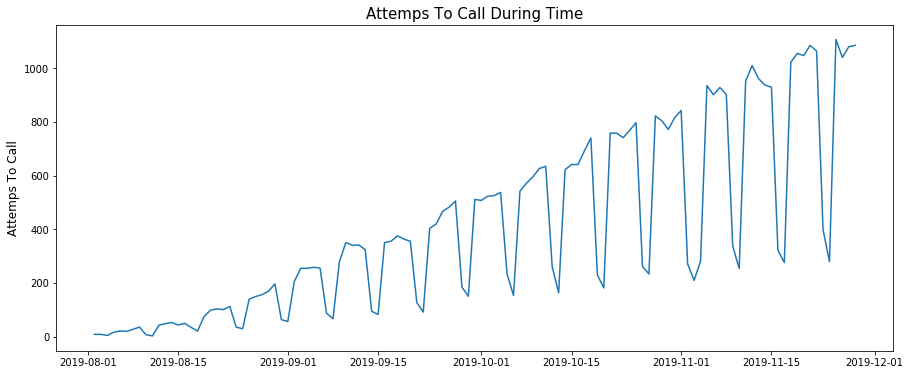

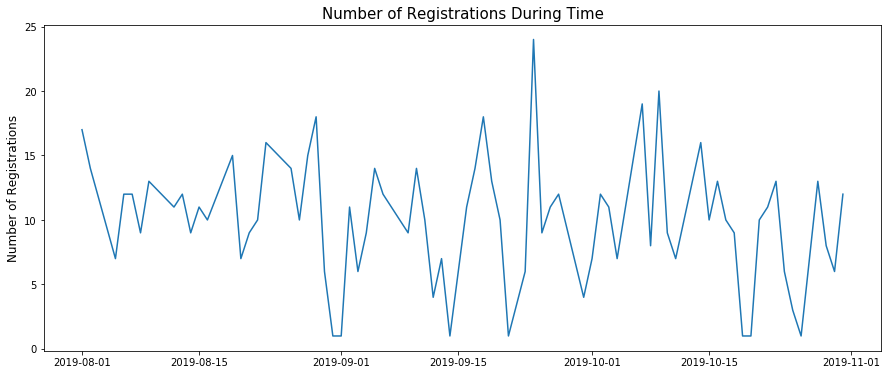

In [24]:
# Plot attemps to call during time
attemps_time = data.groupby('date').agg({
    'calls_count': 'count'}).reset_index().rename(
    columns={'calls_count': 'attemps_to_call'})

fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(attemps_time.date, attemps_time.attemps_to_call)
plt.title('Attemps To Call During Time', fontsize=15)
plt.ylabel('Attemps To Call', fontsize=12)
plt.show()

# Plot registrations during time
reg_time = clients.groupby('date_start').agg({'user_id': 'count'}).reset_index().rename(columns={'user_id': 'reg'})

fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(reg_time.date_start, reg_time.reg)
plt.title('Number of Registrations During Time', fontsize=15)
plt.ylabel('Number of Registrations', fontsize=12)
plt.show()

- <b> There are more attempts to make a call as time goes on. </b>

### direction, internal, missed calls & tariff plan
- Check distribution of call attemps

In [25]:
def category_distribution(df):
    # Gets df with categorical values
    # Prints distribution of categories
    df['amount'] = 1
    for col in df.drop('amount', axis=1).columns:
        grouped = df.groupby(col).agg({'amount': 'count'}).reset_index()
        sns.barplot(x=col, y='amount', data=grouped)
        plt.title('{} distribution'.format(col), fontsize='15')
        plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


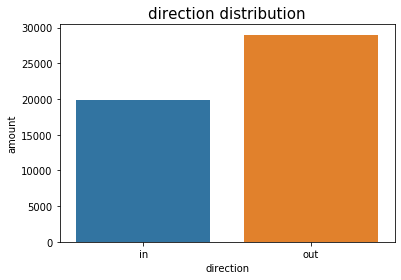

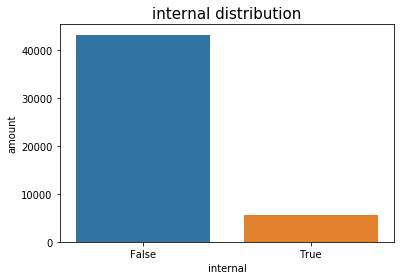

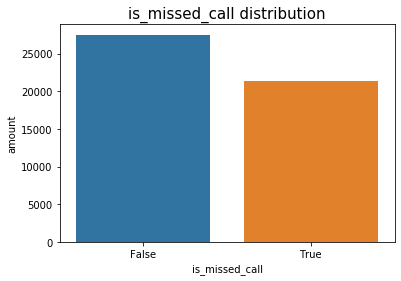

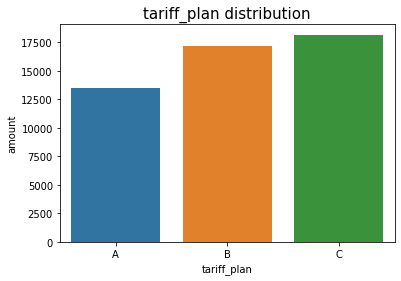

In [26]:
category_distribution(data[['direction', 'internal', 'is_missed_call', 'tariff_plan']])

- <b> Most of call attemps were executed by operators to customers (external). </b>

### Number of calls, call duration & total call duration
- Checking distribution of calls_count, call_duration & total_call_duration, dividng to 2 groups - missed and answered calls.
- When call is missed - call duration suppose to be 0.
- When call is answered - call duration suppose to be bigger than 0.
- Dropping outliers out!

### Calls_count

In [27]:
data[['calls_count']].describe()

,calls_count
count,48892.000000
mean,16.495214
std,63.671633
min,1.000000
25%,1.000000
50%,4.000000
75%,12.000000
max,4817.000000


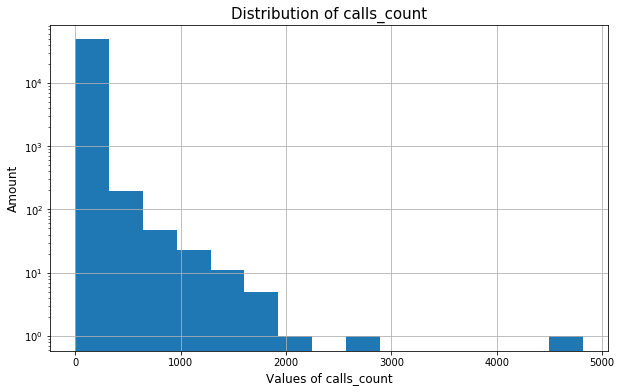

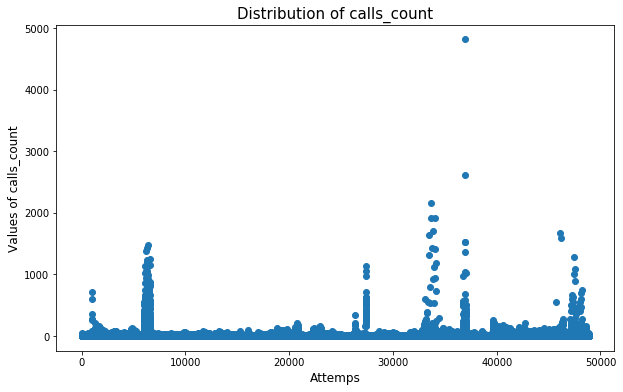

Array of outliers for calls_count - 90%, 92%, 95%, 97% ,99%
[ 35.    43.    62.    84.   165.09]


In [28]:
def plot_distribution(df):
    # Gets df with numerical values.
    # Plots histogram & Scatter plot for each column.
    # Prints outliers: 90%, 92%, 95%, 97%, 99%
    for col in df.columns:
        # Plots histogram
        fig, ax = plt.subplots(figsize=(10, 6))
        df[col].hist(log=True, bins=15)
        plt.title('Distribution of {}'.format(col), fontsize=15)
        plt.xlabel('Values of {}'.format(col), fontsize=12)
        plt.ylabel('Amount', fontsize=12)
        plt.show()
        # Plots scatter plot
        fig, ax = plt.subplots(figsize=(10, 6))
        x_values = pd.Series(range(0, len(df[col])))
        plt.scatter(x_values, df[col])
        plt.title('Distribution of {}'.format(col), fontsize=15)
        plt.xlabel('Attemps', fontsize=12)
        plt.ylabel('Values of {}'.format(col), fontsize=12)
        plt.show()
        # Prints outliers by percentiles
        print('Array of outliers for {} - 90%, 92%, 95%, 97% ,99%'.format(col))
        print(np.percentile(df[col], [90, 92, 95, 97, 99]))

plot_distribution(data[['calls_count']])

<b> Outliers: </b>
- Trying 35 times a day (90% percentile) to make a call it's really crazy. I know it means that 10% of data are outliers, but I prefer to work with less & good data instead of showing fictional results.
- The difference between the mean and the median it's also a bad sign.
- For now I'll mark this call attemps.

In [29]:
# Mark call attemps outliers
PERC_LIMIT =  90
calls_count_limit = round(np.percentile(data.calls_count, PERC_LIMIT))
data['calls_count_outliers'] = data.calls_count >= calls_count_limit
# Show difference in distribution 
data.query('calls_count < @calls_count_limit')[['calls_count']].describe()

,calls_count
count,43913.000000
mean,6.324300
std,7.364945
min,1.000000
25%,1.000000
50%,3.000000
75%,8.000000
max,34.000000


### Call_duration,  total_call_duration & wait_duration
- Diffrerent check for missing & answered calls.
- Checking that call_duration is not bigger than total_call_duration.
- For answered calls - call_duration is bigger than 0.
- For missing calls - call_duration is 0.

In [30]:
# Checking that call_duration is not bigger than total_call_duration
len(data.query('call_duration > total_call_duration'))

0

### For answered calls

In [31]:
# Mark answered calls
data_ans = data.query('is_missed_call == False')
data_ans[['call_duration', 'total_call_duration', 'wait_duration']].describe()

,call_duration,total_call_duration,wait_duration
count,27495.000000,27495.000000,27495.000000
mean,1542.786725,1785.620767,242.834043
std,4935.760863,5743.266730,921.643894
min,0.000000,0.000000,0.000000
25%,109.000000,138.000000,19.000000
50%,445.000000,515.000000,54.000000
75%,1424.000000,1651.000000,177.000000
max,144395.000000,166155.000000,46474.000000


In [32]:
print('Number of answered calls with 0-3 seconds for call duration: ', len(data_ans.query('call_duration <= 3')))

Number of answered calls with 0-3 seconds for call duration:  239


In [33]:
2400 / 3600

0.6666666666666666

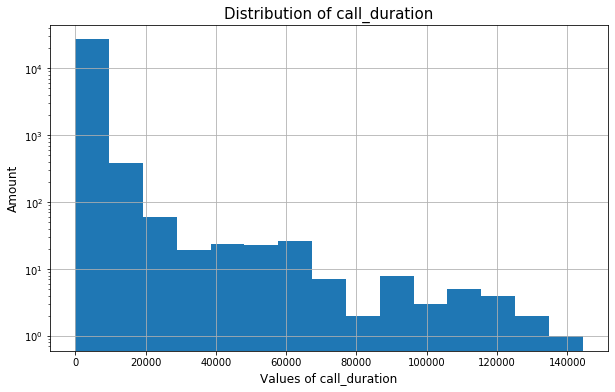

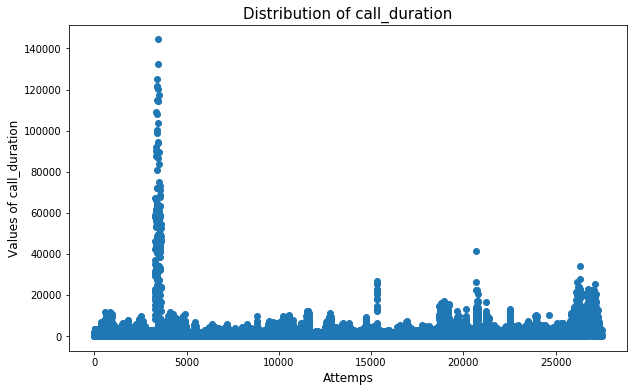

Array of outliers for call_duration - 90%, 92%, 95%, 97% ,99%
[ 3392.8   4044.92  5633.3   7820.18 13998.44]


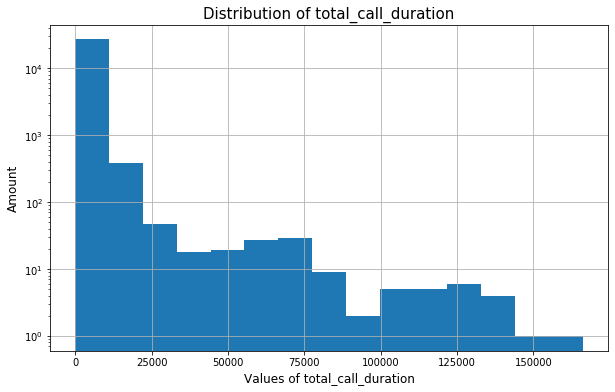

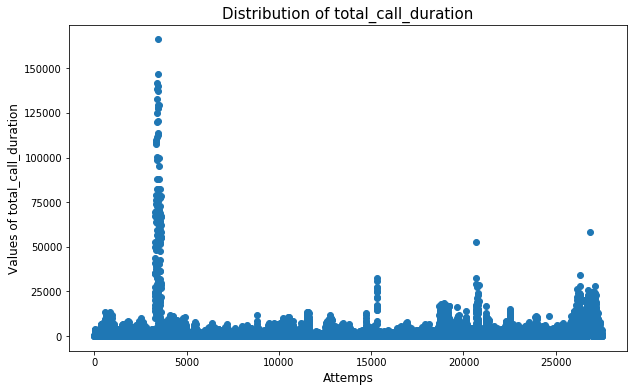

Array of outliers for total_call_duration - 90%, 92%, 95%, 97% ,99%
[ 3910.2   4614.96  6419.    8914.72 16139.78]


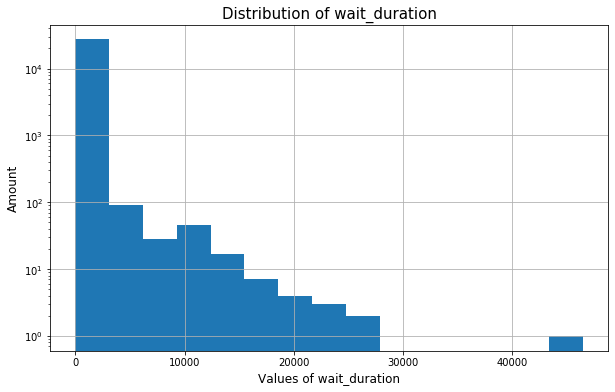

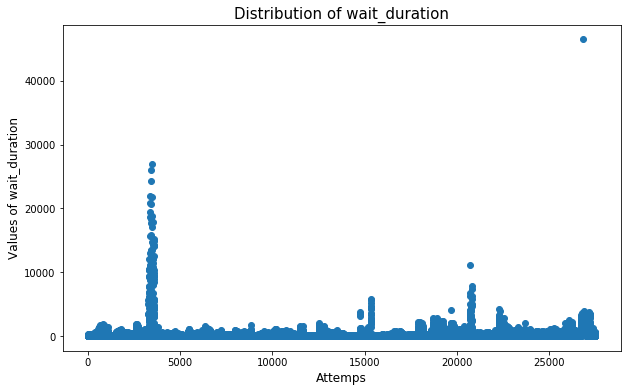

Array of outliers for wait_duration - 90%, 92%, 95%, 97% ,99%
[ 510.    632.    958.3  1366.18 2454.  ]


In [34]:
plot_distribution(data_ans[['call_duration', 'total_call_duration', 'wait_duration']])

<b> Outliers: </b>
1. call_duration: 
    - Too short calls (between 0-3 seconds) - it's probably techincal  issue or call that immediately was diconnected. This type of calls occured less than 300 times.
    - Too long calls - more than 1.5 hours (about 8% of total data).
2. total_call_duration - too long calls - more than 2.5 hours (about 3% of  total data).
3. wait_call_duration - too long wait - more than 45 minutes (about 1% of total data).

For now i'll mark them as suspicious, at the end of the EDA i'll see the whole picture and will get a decision.

In [35]:
# Mark outliers
SHORT_CALL_DURATION_LIMIT = 3
LONG_CALL_DURATION_LIMIT = np.percentile(data_ans['call_duration'], 92)
data['call_duration_outliers'] = (data['is_missed_call'] == False) & ((
    data.call_duration <= SHORT_CALL_DURATION_LIMIT) | (
    data.call_duration >= LONG_CALL_DURATION_LIMIT))

LONG_TOTAL_CALL_DURATION_LIMIT = np.percentile(data_ans['total_call_duration'], 97)
data['total_call_duration_outliers'] = (data['is_missed_call'] == False) & (
    data.call_duration >= LONG_TOTAL_CALL_DURATION_LIMIT)

LONG_WAIT_CALL_DURATION_LIMIT = np.percentile(data_ans['wait_duration'], 99)
data['wait_duration_outliers'] = (data['is_missed_call'] == False) & (
    data.call_duration >= LONG_WAIT_CALL_DURATION_LIMIT)

In [36]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,wait_duration,tariff_plan,date_start,calls_count_outliers,call_duration_outliers,total_call_duration_outliers,wait_duration_outliers
0,166377,2019-08-04,in,False,1.0,True,2,0,4,4,B,2019-08-01,False,False,False,False
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,5,B,2019-08-01,False,False,False,False
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,1,B,2019-08-01,False,False,False,False
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,8,B,2019-08-01,False,False,False,False
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,25,B,2019-08-01,False,False,False,False


### For missing calls

In [37]:
data_miss = data.query('is_missed_call == True')
data_miss[['call_duration', 'total_call_duration', 'wait_duration']].describe()

,call_duration,total_call_duration,wait_duration
count,21397.000000,21397.000000,21397.000000
mean,1.106510,353.742768,352.636257
std,17.896334,1355.145890,1355.297320
min,0.000000,0.000000,0.000000
25%,0.000000,14.000000,13.000000
50%,0.000000,60.000000,58.000000
75%,0.000000,240.000000,239.000000
max,741.000000,45312.000000,45312.000000


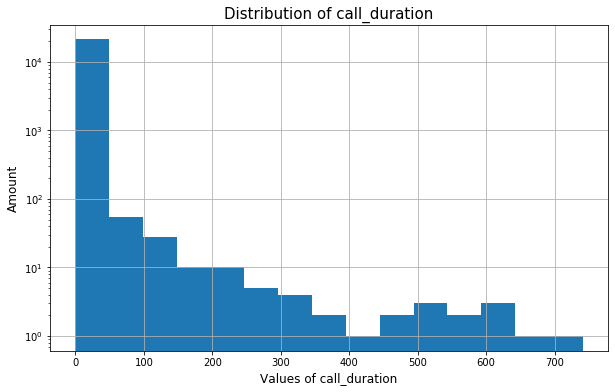

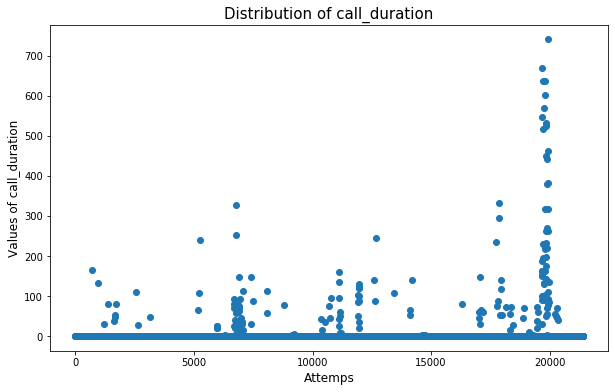

Array of outliers for call_duration - 90%, 92%, 95%, 97% ,99%
[0. 0. 0. 0. 1.]


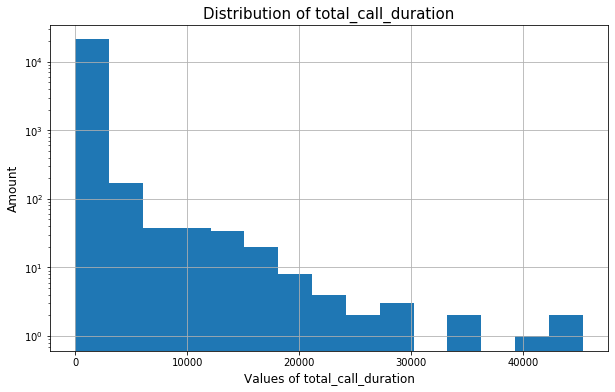

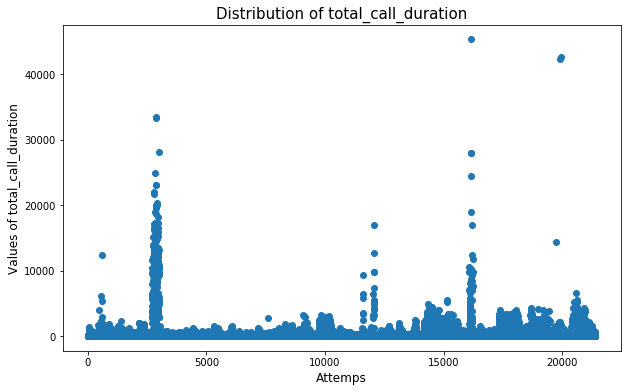

Array of outliers for total_call_duration - 90%, 92%, 95%, 97% ,99%
[ 771.4   961.   1422.   1977.12 4030.88]


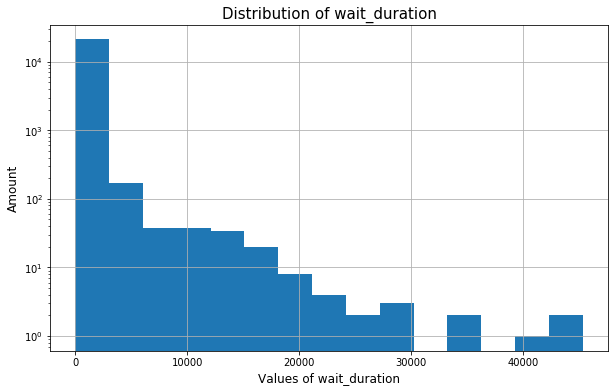

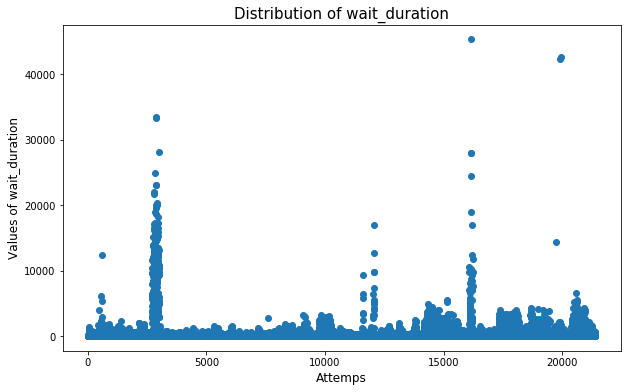

Array of outliers for wait_duration - 90%, 92%, 95%, 97% ,99%
[ 771.4   961.   1422.   1977.12 4030.88]


In [38]:
plot_distribution(data_miss[['call_duration', 'total_call_duration', 'wait_duration']])

In [39]:
len(data_miss.query('call_duration > 0'))

295

<b> Outliers: </b> 
1. call_duration - Time suppose to be 0, but there are 295 calls with bigger time, so I'm going to reset them.
2. total_call_duration & wait_duration - too long calls - more than 1.5 hours (about 1% of  total data), so I'll mark them.

In [40]:
# Reset call_duration, total_call_duration & wait_duration for missing calls 
data.loc[data['is_missed_call'] == True, 'total_call_duration'] = data.total_call_duration - data.call_duration
data.loc[data['is_missed_call'] == True, 'call_duration'] = 0
data['wait_duration'] = data.total_call_duration - data.call_duration

In [41]:
# Mark wait_duration outliers
LONG_TOTAL_CALL_DURATION_LIMIT = np.percentile(data_miss['total_call_duration'], 99)
data.loc[data['is_missed_call'] == True, 'total_call_duration_outliers'] = data.call_duration >= LONG_TOTAL_CALL_DURATION_LIMIT

LONG_WAIT_CALL_DURATION_LIMIT = np.percentile(data_miss['wait_duration'], 99)
data.loc[data['is_missed_call'] == True, 'wait_duration_outliers'] = data.call_duration >= LONG_WAIT_CALL_DURATION_LIMIT

### Looking at all outliers

In [42]:
outliers = data.query('calls_count_outliers == True or call_duration_outliers == True or total_call_duration_outliers == True or wait_duration_outliers == True')
print('Number of outliers: ', len(outliers))
print('% of Outliers: {:.2%}'.format(len(outliers) / len(data)))

Number of outliers:  7047
% of Outliers: 14.41%


<b> <u> I decided to drop outliers out. </b> </u> 
 - This data is  really messy, and I prefer to loose 14.5% of data and work with valids.

In [43]:
# Drop outliers
data = data.query('calls_count_outliers == False and call_duration_outliers == False and total_call_duration_outliers == False and wait_duration_outliers == False')
data = data.drop(['calls_count_outliers', 'call_duration_outliers', 'total_call_duration_outliers',
                  'wait_duration_outliers'], axis=1)

In [44]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,wait_duration,tariff_plan,date_start
0,166377,2019-08-04,in,False,1.0,True,2,0,4,4,B,2019-08-01
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,5,B,2019-08-01
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,1,B,2019-08-01
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,8,B,2019-08-01
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,25,B,2019-08-01


### Show distribution without outliers

In [45]:
# Answered calls
data_ans1 = data.query('is_missed_call == False')
data_ans1[['calls_count', 'call_duration', 'total_call_duration', 'wait_duration']].describe()

,calls_count,call_duration,total_call_duration,wait_duration
count,22671.000000,22671.000000,22671.000000,22671.000000
mean,5.862115,535.046668,617.768162,82.721494
std,6.614493,586.992050,661.897083,112.410761
min,1.000000,4.000000,4.000000,0.000000
25%,1.000000,86.000000,112.000000,16.000000
50%,3.000000,296.000000,349.000000,39.000000
75%,8.000000,801.000000,923.000000,101.000000
max,34.000000,2452.000000,3834.000000,1463.000000


In [46]:
# Missing calls
data_miss1 = data.query('is_missed_call == True')
data_miss1[['calls_count', 'call_duration', 'total_call_duration', 'wait_duration']].describe()

,calls_count,call_duration,total_call_duration,wait_duration
count,19174.000000,19174.0,19174.000000,19174.000000
mean,5.744028,0.0,121.162773,121.162773
std,7.036729,0.0,181.485246,181.485246
min,1.000000,0.0,0.000000,0.000000
25%,1.000000,0.0,11.000000,11.000000
50%,3.000000,0.0,45.000000,45.000000
75%,7.000000,0.0,151.000000,151.000000
max,34.000000,0.0,2187.000000,2187.000000


### Operator_id
- Describe distribution of recieve and make calls - Does everyone do both?
- Check distribution of call attemps - How many calls do they do?

In [47]:
# Describe distribution of operators' type of work
oper_dir = data.pivot_table(index='operator_id', columns='direction', values='calls_count', aggfunc='count'
                           ).reset_index().fillna(0)
oper_dir.columns = ['operator_id','in_calls', 'out_calls']
oper_dir['total_calls'] =  oper_dir.in_calls + oper_dir.out_calls
oper_dir.sort_values(by='total_calls')

,operator_id,in_calls,out_calls,total_calls
1082,973286.0,1.0,0.0,1.0
711,937872.0,0.0,1.0,1.0
696,937778.0,0.0,1.0,1.0
694,937772.0,0.0,1.0,1.0
693,937770.0,0.0,1.0,1.0
...,...,...,...,...
49,889410.0,79.0,163.0,242.0
191,900892.0,84.0,159.0,243.0
34,887276.0,67.0,196.0,263.0
204,901884.0,88.0,193.0,281.0


### Show distribution of calls without empty operators

For those who receive calls

In [48]:
oper_dir.query('operator_id != 1 and out_calls ').drop('operator_id', axis=1).describe()

,in_calls,out_calls,total_calls
count,874.000000,874.000000,874.000000
mean,10.707094,26.664760,37.371854
std,16.900796,33.833748,46.506231
min,0.000000,1.000000,1.000000
25%,0.000000,4.000000,5.000000
50%,2.000000,12.500000,18.000000
75%,14.750000,37.000000,52.000000
max,106.000000,196.000000,281.000000


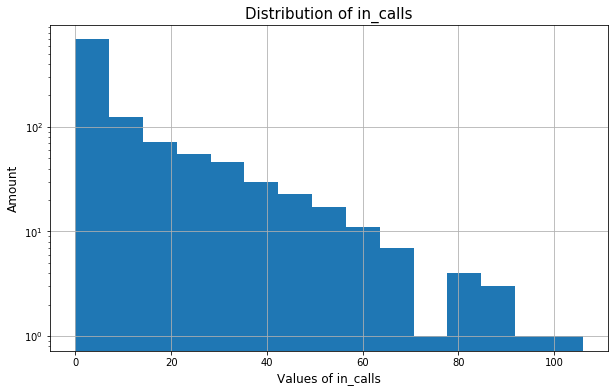

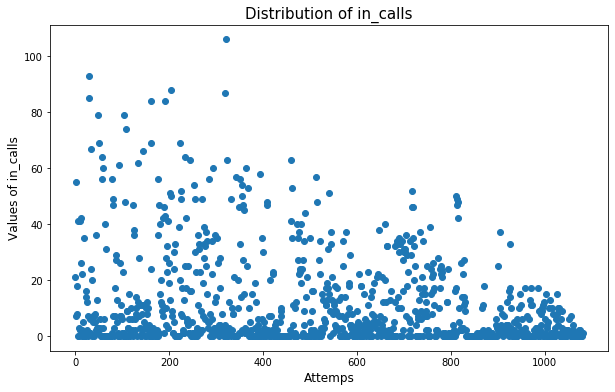

Array of outliers for in_calls - 90%, 92%, 95%, 97% ,99%
[34.   37.   47.95 55.57 69.  ]


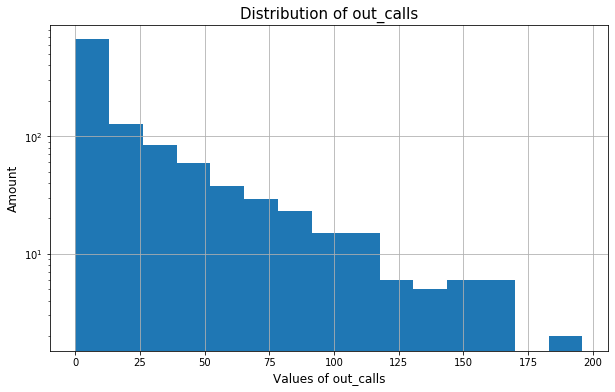

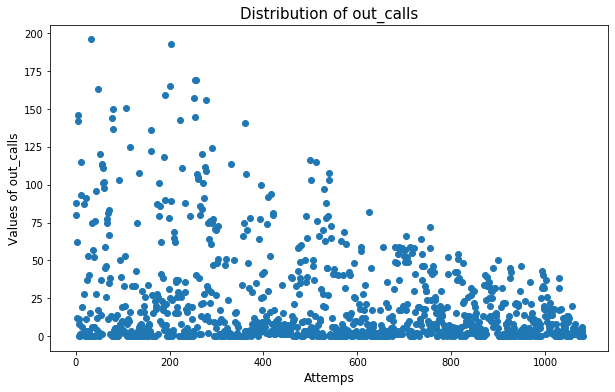

Array of outliers for out_calls - 90%, 92%, 95%, 97% ,99%
[ 65.    75.52  91.95 111.   146.76]


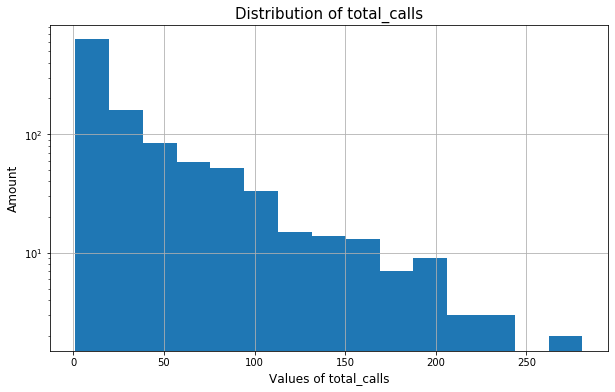

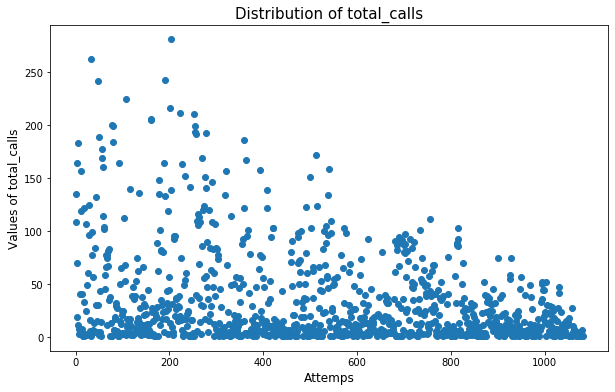

Array of outliers for total_calls - 90%, 92%, 95%, 97% ,99%
[ 91.   100.52 122.95 157.   199.19]


In [49]:
plot_distribution(oper_dir.query('operator_id != 1').drop('operator_id', axis=1))

## We can see that not all  of the operators receive & make calls (in&out direction)
<b> <u> It means that we need to separate the operators to 2 groups - receive and make. </u> </b> It's not right to measure operators that only receive incoming calls by the number of outgoing calls, for example.

### Show distribution of operators that receive calls

In [50]:
# Describe distribution of operators' type of work
oper_dir = data.query('direction == "in"').pivot_table(index='operator_id', columns='direction', values='calls_count', aggfunc='count'
                           ).reset_index().fillna(0)
oper_dir.columns = ['operator_id','in_calls']
oper_dir.sort_values(by='in_calls')

,operator_id,in_calls
750,973286.0,1
449,932498.0,1
711,960294.0,1
321,918958.0,1
633,948282.0,1
...,...,...
252,908958.0,87
155,901884.0,88
23,885890.0,93
253,908960.0,106


In [51]:
oper_dir.query('operator_id != 1').drop('operator_id', axis=1).describe()

,in_calls
count,750.000000
mean,15.481333
std,17.679661
min,1.000000
25%,2.250000
50%,8.500000
75%,23.000000
max,106.000000


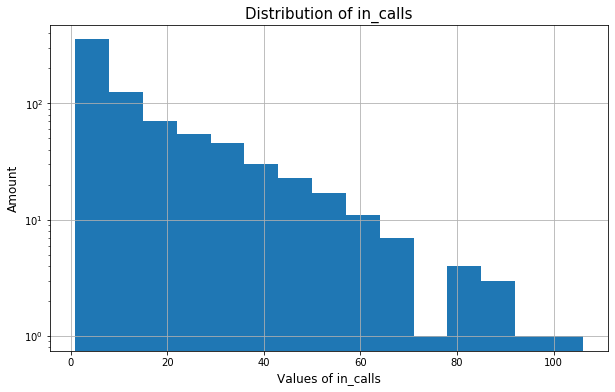

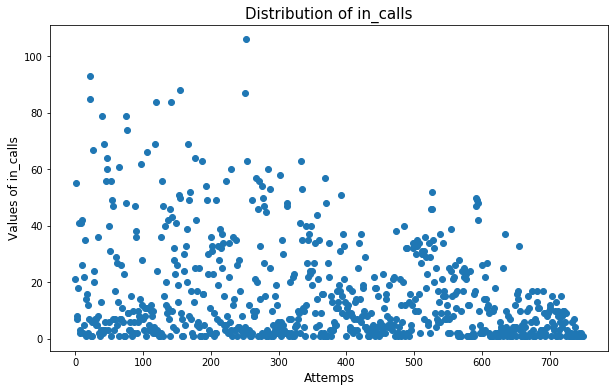

Array of outliers for in_calls - 90%, 92%, 95%, 97% ,99%
[41.   47.   52.55 60.   79.  ]


In [52]:
plot_distribution(oper_dir.query('operator_id != 1').drop('operator_id', axis=1))

### Show distribution of operators that make calls

In [53]:
# Describe distribution of operators' type of work
oper_dir = data.query('direction == "out"').pivot_table(index='operator_id', columns='direction', values='calls_count', aggfunc='count'
                           ).reset_index().fillna(0)
oper_dir.columns = ['operator_id','out_calls']
oper_dir.sort_values(by='out_calls')

,operator_id,out_calls
829,961064.0,1
491,932246.0,1
75,891918.0,1
292,914272.0,1
852,969262.0,1
...,...,...
0,1.0,165
203,905564.0,169
204,905566.0,169
164,901884.0,193


In [54]:
oper_dir.query('operator_id != 1').drop('operator_id', axis=1).describe()

,out_calls
count,874.000000
mean,26.664760
std,33.833748
min,1.000000
25%,4.000000
50%,12.500000
75%,37.000000
max,196.000000


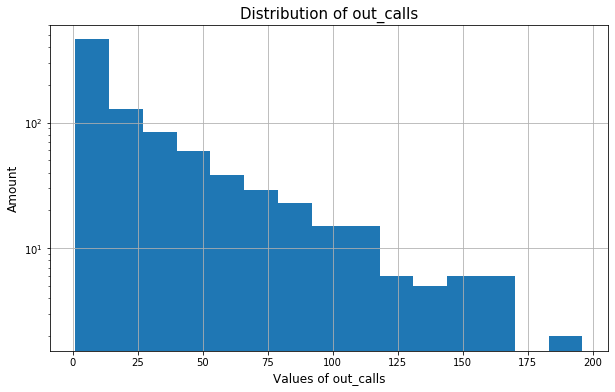

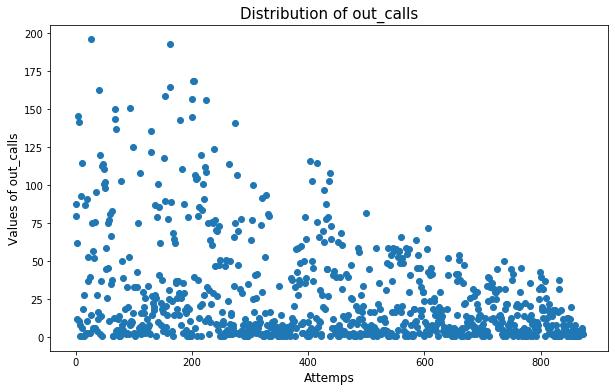

Array of outliers for out_calls - 90%, 92%, 95%, 97% ,99%
[ 75.    81.   102.35 115.   152.35]


In [55]:
plot_distribution(oper_dir.query('operator_id != 1').drop('operator_id', axis=1))

In [56]:
### Number of operators that receive and make calls both
len(data.groupby('operator_id').agg({'direction': 'nunique'}).query('direction == 2'))

543

In [57]:
data.groupby('operator_id').agg({'direction': 'nunique'}).query('direction == 2').reset_index().head()

,operator_id,direction
0,1.0,2
1,879896.0,2
2,879898.0,2
3,880020.0,2
4,880022.0,2


### 1082 operators  - 750 receive calls, 874 make calls, 542 do both (not included empties).

### Checking correlations between the columns

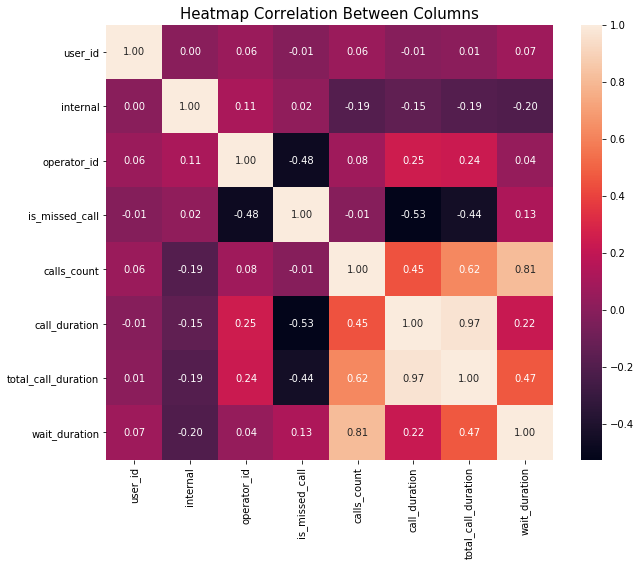

In [58]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt='.2f', ax=ax)
plt.title('Heatmap Correlation Between Columns', fontsize=15)
plt.show()

<b> 1. There's a strong correlation between 'call_duration' and 'total_call_duration' (97%) </b> - which is obvious.

<b> 2. There's an interesting correlation between 'calls_count' and 'wait_duration' (81%) </b> - It may mean that ineffective operators have big number of missing calls and long waiting time, we'll check it out! 

###  Adding columns for number of successful & missing calls

In [59]:
data['missed_calls'] = data['calls_count']
data.loc[data['is_missed_call']  == False, 'missed_calls'] -=  1
data['succ_calls'] = 0
data.loc[data['is_missed_call']  == False, 'succ_calls'] =  1
data = data[['user_id', 'date', 'direction', 'internal', 'operator_id',
       'is_missed_call', 'calls_count', 'missed_calls', 'succ_calls', 'call_duration', 'total_call_duration',
       'wait_duration', 'tariff_plan', 'date_start']]

In [60]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,missed_calls,succ_calls,call_duration,total_call_duration,wait_duration,tariff_plan,date_start
0,166377,2019-08-04,in,False,1.0,True,2,2,0,0,4,4,B,2019-08-01
1,166377,2019-08-05,out,True,880022.0,True,3,3,0,0,5,5,B,2019-08-01
2,166377,2019-08-05,out,True,880020.0,True,1,1,0,0,1,1,B,2019-08-01
3,166377,2019-08-05,out,True,880020.0,False,1,0,1,10,18,8,B,2019-08-01
4,166377,2019-08-05,out,False,880022.0,True,3,3,0,0,25,25,B,2019-08-01


#  <a id="third_step"> Third stage - define effective & ineffective operators: </a> 
- <b> We saw during the EDA that not all of the operators make outgoing calls and also receive incoming calls ('direction' in & out). </b>


- <b> It means that we need to analzye this 2 kinds of operators separately - </b> It's not right to measure operatorot s that only receive incoming calls by the number of outgoing calls, for example.


- <b> Give a rank for operators that make outgoing calls ('out' direction) based on: </b>
    - Number of successful outgoing calls (call is not missed, conversation was occurred) - measure by quantity.
    - Percent of successul outgoing calls (call is not missed, conversation was occurred) - measure by quality.
    - Time call - distance from the mean, normality leads; not too long, not too short.


- <b> Give a rank for operators that receive incoming calls ('in' direction) based on: </b>
    - Number of successful incoming calls (call is not missed, conversation was occurred) - measure by quantity.
    - Percent of missing incoming calls - measure by quality.
    - Wait Time call - the less it the best.


###  Define operators that make outgoing calls ('out' direction')

In [61]:
out_data = data.query('direction == "out"')

In [62]:
# Calculate number of successful calls & percent of success
out_data_calls = out_data.groupby('operator_id').agg({'calls_count': 'sum','succ_calls': 'sum'}).reset_index()
out_data_calls['succ_perc'] = round(out_data_calls.succ_calls / out_data_calls.calls_count * 100, 2)
out_data_calls.head()

,operator_id,calls_count,succ_calls,succ_perc
0,1.0,237,26,10.97
1,879896.0,475,41,8.63
2,879898.0,1265,20,1.58
3,880020.0,36,6,16.67
4,880022.0,189,33,17.46


In [63]:
# Calculate average time call 
out_data_time_call = out_data.query('is_missed_call == False').groupby('operator_id').agg({
    'call_duration':  'mean'}).reset_index().rename(columns={'call_duration': 'avg_call_duration'})

# Calculate absolute distance from the mean
out_data_time_call['abs_dist_mean'] = abs(
out_data_time_call['avg_call_duration'] - out_data_time_call['avg_call_duration'].mean())
out_data_time_call.head()

,operator_id,avg_call_duration,abs_dist_mean
0,1.0,707.384615,173.947610
1,879896.0,460.902439,72.534567
2,879898.0,727.850000,194.412994
3,880020.0,323.833333,209.603672
4,880022.0,443.484848,89.952157


In [64]:
out_data_time_call[['avg_call_duration']].describe()

,avg_call_duration
count,774.000000
mean,533.437006
std,482.984234
min,4.000000
25%,144.625000
50%,388.465116
75%,785.848485
max,2344.000000


In [65]:
print("Number of operators that didn't succeed to make a call:" , len(out_data_calls) - len(out_data_time_call))

Number of operators that didn't succeed to make a call: 101


### We  can see that 101 operators didn't succeed to make a call! 
Their rank has to be the lowest - so we'll give them the biggest value of absolute distance from the mean

In [66]:
# Merge data of calls & time
out_data_grouped  = out_data_calls.merge(out_data_time_call,  on='operator_id', how='left')

# Sign for unsuccessful calls = value of 10,000
out_data_grouped.loc[out_data_grouped['avg_call_duration'].isnull(), 'avg_call_duration'] = 10000
out_data_grouped.loc[out_data_grouped['abs_dist_mean'].isnull(), 'abs_dist_mean'] = 10000

# Round time results
out_data_grouped['avg_call_duration'] = round(out_data_grouped['avg_call_duration'] , 2)
out_data_grouped['abs_dist_mean'] = round(out_data_grouped['abs_dist_mean'] , 2)
out_data_grouped.head()

,operator_id,calls_count,succ_calls,succ_perc,avg_call_duration,abs_dist_mean
0,1.0,237,26,10.97,707.38,173.95
1,879896.0,475,41,8.63,460.90,72.53
2,879898.0,1265,20,1.58,727.85,194.41
3,880020.0,36,6,16.67,323.83,209.60
4,880022.0,189,33,17.46,443.48,89.95


### Rank results
- succ_calls - the more, the best
- succ_perc - the higher,  the best
- abs_dist_mean - the less, the best

In [67]:
def oper_rank(total_rank):
    # Gets rank (number)
    # returns number of group the rank is  belonged.
    # 3-5: Ineffective
    # 6-9: Average
    # 10-12: Effective
    if total_rank < 6:
        return 1
    elif total_rank < 10:
        return 2
    return 3

In [68]:
# Set default values for groups
Q = 4
RANGE_ASC = range(1, Q +  1)
RANGE_DESC = range(Q, 0, -1)

# Rank number of successful calls
out_data_grouped = out_data_grouped.sort_values(by='succ_calls')
out_data_grouped['succ_calls_rank'] = pd.qcut(out_data_grouped['succ_calls'], Q , labels=RANGE_ASC).astype('int')

# Rank percent of successful calls
out_data_grouped = out_data_grouped.sort_values(by='succ_perc')
out_data_grouped['succ_perc_rank'] = pd.qcut(out_data_grouped['succ_perc'], Q , labels=RANGE_ASC).astype('int')

# Rank average time call
out_data_grouped = out_data_grouped.sort_values(by='abs_dist_mean')
out_data_grouped['call_duration_rank'] = pd.qcut(out_data_grouped['abs_dist_mean'], Q , labels=RANGE_DESC).astype('int')

out_data_grouped['total_rank'] = out_data_grouped.succ_calls_rank + out_data_grouped.succ_perc_rank + out_data_grouped.call_duration_rank

#out_data_grouped['avg_rank'] = round((out_data_grouped.succ_calls_rank
#                                        + out_data_grouped.succ_perc_rank + 
#                                        out_data_grouped.call_duration_rank) / 3)

out_data_grouped['rank_group'] = out_data_grouped['total_rank'].apply(oper_rank)

out_data_grouped = out_data_grouped.sort_values(by=['total_rank', 'rank_group'])
out_data_grouped

,operator_id,calls_count,succ_calls,succ_perc,avg_call_duration,abs_dist_mean,succ_calls_rank,succ_perc_rank,call_duration_rank,total_rank,rank_group
763,952466.0,42,1,2.38,1098.00,564.56,1,1,1,3,1
680,945284.0,335,1,0.30,1148.00,614.56,1,1,1,3,1
694,945318.0,332,1,0.30,1281.00,747.56,1,1,1,3,1
771,953458.0,38,1,2.63,1327.00,793.56,1,1,1,3,1
367,919482.0,76,1,1.32,1449.00,915.56,1,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...
230,906416.0,77,22,28.57,604.14,70.70,4,4,4,12,3
467,929876.0,78,24,30.77,428.71,104.73,4,4,4,12,3
322,917856.0,74,21,28.38,428.43,105.01,4,4,4,12,3
239,907224.0,299,81,27.09,342.40,191.04,4,4,4,12,3


### Done!

### Define operators that receive calls ('in' direction)

In [69]:
in_data = data.query('direction == "in"')

In [70]:
# Calculate number of missed calls & percent of missed
in_data_calls = in_data.groupby('operator_id').agg({'calls_count': 'sum','succ_calls': 'sum', 
                                                    'missed_calls': 'sum'}).reset_index()
in_data_calls['miss_perc'] = round(in_data_calls.missed_calls / in_data_calls.calls_count * 100, 2)
in_data_calls.head()

,operator_id,calls_count,succ_calls,missed_calls,miss_perc
0,1.0,32140,42,32098,99.87
1,879896.0,58,21,37,63.79
2,879898.0,102,55,47,46.08
3,880020.0,7,7,0,0.00
4,880022.0,8,8,0,0.00


In [71]:
# Calculate average wait time 
in_data_time_call = in_data.query('is_missed_call == False').groupby('operator_id').agg({
    'wait_duration':  'mean'}).reset_index().rename(columns={'wait_duration': 'avg_wait_duration'})

in_data_time_call.head()

,operator_id,avg_wait_duration
0,1.0,22.690476
1,879896.0,27.333333
2,879898.0,30.200000
3,880020.0,7.714286
4,880022.0,14.000000


In [72]:
in_data_time_call[['avg_wait_duration']].describe()

,avg_wait_duration
count,747.000000
mean,50.161127
std,67.862003
min,1.000000
25%,17.583333
50%,31.000000
75%,56.599286
max,753.100000


In [73]:
print("Number of operators that didn't succeed to make a call:" , len(in_data_calls) - len(in_data_time_call))

Number of operators that didn't succeed to make a call: 4


### We can see that only 4 operators didn't succeed to make a call
Their rank has to be the lowest - so we'll give them the biggest value of wait duration.

In [74]:
# Merge data of calls & time
in_data_grouped  = in_data_calls.merge(in_data_time_call,  on='operator_id', how='left')

# Sign for unsuccessful calls = value of 1000
in_data_grouped.loc[in_data_grouped['avg_wait_duration'].isnull(), 'avg_wait_duration'] = 1000

# Round average wait duration
in_data_grouped['avg_wait_duration'] = round(in_data_grouped['avg_wait_duration'] , 2)

in_data_grouped.head()

,operator_id,calls_count,succ_calls,missed_calls,miss_perc,avg_wait_duration
0,1.0,32140,42,32098,99.87,22.69
1,879896.0,58,21,37,63.79,27.33
2,879898.0,102,55,47,46.08,30.20
3,880020.0,7,7,0,0.00,7.71
4,880022.0,8,8,0,0.00,14.00


### Rank results
- succ_calls - the more, the best
- miss_perc - the lowest,  the best
- avg_wait_duration - the less, the best

In [75]:
# Set default values for groups
Q = 4
RANGE_ASC = range(1, Q +  1)
RANGE_DESC = range(Q, 0, -1)

# Rank number of successful calls
in_data_grouped = in_data_grouped.sort_values(by='succ_calls')
in_data_grouped['succ_calls_rank'] = pd.qcut(in_data_grouped['succ_calls'], Q , labels=RANGE_ASC).astype('int')

# Rank percent of successful calls
in_data_grouped = in_data_grouped.sort_values(by='miss_perc')
in_data_grouped['miss_perc_rank'] = pd.qcut(in_data_grouped['miss_perc'], Q , labels=RANGE_DESC).astype('int')

# Rank average time call
in_data_grouped = in_data_grouped.sort_values(by='avg_wait_duration')
in_data_grouped['avg_wait_duration_rank'] = pd.qcut(in_data_grouped['avg_wait_duration'], Q , labels=RANGE_DESC).astype('int')

in_data_grouped['total_rank'] = in_data_grouped.succ_calls_rank + in_data_grouped.miss_perc_rank + in_data_grouped.avg_wait_duration_rank

#in_data_grouped['avg_rank'] = round((in_data_grouped.succ_calls_rank
#                                        + in_data_grouped.miss_perc_rank + 
#                                        in_data_grouped.avg_wait_duration_rank) / 3)

in_data_grouped['rank_group'] = in_data_grouped['total_rank'].apply(oper_rank)

in_data_grouped = in_data_grouped.sort_values(by=['total_rank', 'rank_group'])
in_data_grouped

,operator_id,calls_count,succ_calls,missed_calls,miss_perc,avg_wait_duration,succ_calls_rank,miss_perc_rank,avg_wait_duration_rank,total_rank,rank_group
678,954086.0,31,1,30,96.77,64.00,1,1,1,3,1
173,903974.0,10,2,8,80.00,83.50,1,1,1,3,1
118,898920.0,13,2,11,84.62,97.00,1,1,1,3,1
111,898414.0,24,2,22,91.67,126.00,1,1,1,3,1
12,882688.0,15,2,13,86.67,336.50,1,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...
99,896014.0,14,12,2,14.29,15.75,3,4,4,11,3
86,895170.0,11,10,1,9.09,16.10,3,4,4,11,3
132,900492.0,17,14,3,17.65,16.29,3,4,4,11,3
374,923944.0,40,27,13,32.50,17.37,4,3,4,11,3


### Done!

#  <a id="fourth_step">  Fourth stage: Test statistical hypotheses </a> 
<b> <u> Effective operators:</u> group 3 </b>

<b> <u> Average operators: </u> group 2  </b>  

<b> <u> Ineffective operators: </u> group 1  </b>    

In [76]:
in_data_grouped.query('operator_id  == 1')

,operator_id,calls_count,succ_calls,missed_calls,miss_perc,avg_wait_duration,succ_calls_rank,miss_perc_rank,avg_wait_duration_rank,total_rank,rank_group
0,1.0,32140,42,32098,99.87,22.69,4,1,3,8,2


We can see that the empty operators are in the average group (rank 2), but their values are outliers. So the best thing to do before using statistics is to drop them out,  they mislead us!

In [77]:
out_data_grouped.query('operator_id  == 1')

,operator_id,calls_count,succ_calls,succ_perc,avg_call_duration,abs_dist_mean,succ_calls_rank,succ_perc_rank,call_duration_rank,total_rank,rank_group
0,1.0,237,26,10.97,707.38,173.95,4,2,4,10,3


We can see that the empty operators are in the effective group- and their values are normal and not outliers. So we can keep them  in.

In [78]:
# Define effective & ineffective operators that receive calls.
incoming_effective = in_data_grouped.query('rank_group == 3')
incoming_average = in_data_grouped.query('rank_group == 2')
incoming_ineffective = in_data_grouped.query('rank_group == 1')

# Define effective & ineffective operators that make calls.
outgoing_effective = out_data_grouped.query('rank_group == 3')
outgoing_average = out_data_grouped.query('rank_group == 2')
outgoing_ineffective = out_data_grouped.query('rank_group == 1')


### 1) Difference between the average incoming calls waiting time of effective and ineffective operators.

In [79]:
# Looking at effective operators' waiting distribution
incoming_effective[['avg_wait_duration']].describe()

,avg_wait_duration
count,78.000000
mean,15.136667
std,6.348018
min,2.570000
25%,11.000000
50%,14.490000
75%,17.340000
max,30.860000


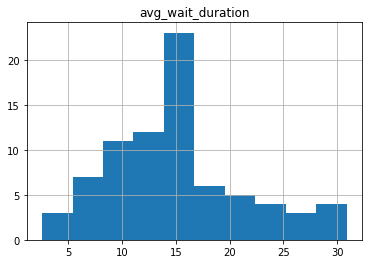

In [80]:
incoming_effective[['avg_wait_duration']].hist()
plt.show()

In [81]:
# Looking at ineffective operators' waiting distribution, without empties that we marked with '1000' value
incoming_ineffective.query('avg_wait_duration != 1000')[['avg_wait_duration']].describe()

,avg_wait_duration
count,97.000000
mean,107.378144
std,110.089654
min,20.000000
25%,54.000000
50%,78.000000
75%,108.430000
max,753.100000


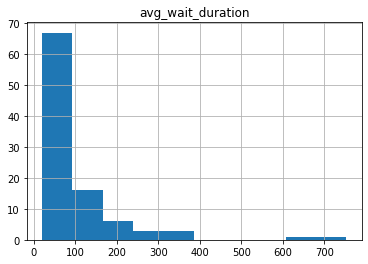

In [82]:
incoming_ineffective.query('avg_wait_duration != 1000')[['avg_wait_duration']].hist()
plt.show()

### The data isn't distributed normally, so we'll use Mann-Whitney test

In [83]:
# Build samples
effective_wait = incoming_effective['avg_wait_duration']
ineffective_wait = incoming_ineffective.query('avg_wait_duration != 1000')['avg_wait_duration']

# General stats
print('Effective operators wait duration - Operators: {} | Wait Average: {:.2f} | Std: {:.2f} \n'.format(
                                                                       effective_wait.count(),
                                                                       effective_wait.mean(),
                                                                       effective_wait.std()))

print('Ineffective operators wait duration - Operators: {} | Wait Average: {:.2f} | Std: {:.2f} \n'.format(
                                                                       ineffective_wait.count(),
                                                                       ineffective_wait.mean(),
                                                                       ineffective_wait.std()))

alpha = 0.05
p_value = st.mannwhitneyu(effective_wait, ineffective_wait)[1]

print('P value is: {0:.5f} \n'.format(p_value))
if p_value < alpha:
    print('Null hypothesis is rejectd: There is a significant difference between the operators waiting duration!')
else:
    print('Failed to reject the null hypothesis: We cannot say that there is a significant difference between the operators!')

Effective operators wait duration - Operators: 78 | Wait Average: 15.14 | Std: 6.35 

Ineffective operators wait duration - Operators: 97 | Wait Average: 107.38 | Std: 110.09 

P value is: 0.00000 

Null hypothesis is rejectd: There is a significant difference between the operators waiting duration!


### 2) Difference between the proportions of missed incoming calls of effective and ineffective operators.
Using Z-test

In [84]:
in_data_grouped

,operator_id,calls_count,succ_calls,missed_calls,miss_perc,avg_wait_duration,succ_calls_rank,miss_perc_rank,avg_wait_duration_rank,total_rank,rank_group
678,954086.0,31,1,30,96.77,64.00,1,1,1,3,1
173,903974.0,10,2,8,80.00,83.50,1,1,1,3,1
118,898920.0,13,2,11,84.62,97.00,1,1,1,3,1
111,898414.0,24,2,22,91.67,126.00,1,1,1,3,1
12,882688.0,15,2,13,86.67,336.50,1,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...
99,896014.0,14,12,2,14.29,15.75,3,4,4,11,3
86,895170.0,11,10,1,9.09,16.10,3,4,4,11,3
132,900492.0,17,14,3,17.65,16.29,3,4,4,11,3
374,923944.0,40,27,13,32.50,17.37,4,3,4,11,3


In [85]:
# group 1 = ineffective
# group 3 = effective

# Number of missed_calls per group
sucesses1 = in_data_grouped.query('rank_group == 1').missed_calls.sum()
sucesses3 = in_data_grouped.query('rank_group == 3').missed_calls.sum()
sucessesCombined = sucesses1 + sucesses3
    
# Number of total_calls per group
trials1 = in_data_grouped.query('rank_group == 1').calls_count.sum()
trials3 = in_data_grouped.query('rank_group == 3').calls_count.sum()
trialsCombined = trials1 + trials3
    
# Share of missed incoming calls per group
p1 = sucesses1 / trials1
p3 = sucesses3 / trials3
pCombined = sucessesCombined / trialsCombined
    
difference = p1 - p3 
distr = st.norm(0, 1)
    
z_value = difference / math.sqrt(pCombined * (1 - pCombined) * (1/trials1 + 1/trials3))
p_value = (1 - distr.cdf(abs(z_value))) * 2
alpha =  0.05
    
print('Effective group: Number of operators: {} | missed calls: {} | total calls: {}  | Proportion: {:.3%} \n'.format(
        len(in_data_grouped.query('rank_group == 3')),
        sucesses3, 
        trials3,
        p3))

print('Inffective group: Number of operators: {} | missed calls: {} | total calls: {}  | Proportion: {:.3%} \n'.format(
        len(in_data_grouped.query('rank_group == 1')),
        sucesses1, 
        trials1,
        p1))

print('H0: There is no significant difference between the proportions of the groups.\n')
print('H1: There is significant difference between the proportions of the groups. \n')
print('Alpha level: {} \n'.format(alpha))
print('RESULTS: p-value: {:.5f} \n'.format(p_value))
if (p_value < alpha):
    print("Rejecting the null hypothesis: there is a significant difference between the proportions")
else:
    print("Failed to reject the null hypothesis: there is no reason to consider the proportions different") 

Effective group: Number of operators: 78 | missed calls: 672 | total calls: 1854  | Proportion: 36.246% 

Inffective group: Number of operators: 101 | missed calls: 5210 | total calls: 5862  | Proportion: 88.878% 

H0: There is no significant difference between the proportions of the groups.

H1: There is significant difference between the proportions of the groups. 

Alpha level: 0.05 

RESULTS: p-value: 0.00000 

Rejecting the null hypothesis: there is a significant difference between the proportions


### 3) Difference between the average number of outgoing calls of effective and ineffective operators. 

In [86]:
out_data_grouped

,operator_id,calls_count,succ_calls,succ_perc,avg_call_duration,abs_dist_mean,succ_calls_rank,succ_perc_rank,call_duration_rank,total_rank,rank_group
763,952466.0,42,1,2.38,1098.00,564.56,1,1,1,3,1
680,945284.0,335,1,0.30,1148.00,614.56,1,1,1,3,1
694,945318.0,332,1,0.30,1281.00,747.56,1,1,1,3,1
771,953458.0,38,1,2.63,1327.00,793.56,1,1,1,3,1
367,919482.0,76,1,1.32,1449.00,915.56,1,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...
230,906416.0,77,22,28.57,604.14,70.70,4,4,4,12,3
467,929876.0,78,24,30.77,428.71,104.73,4,4,4,12,3
322,917856.0,74,21,28.38,428.43,105.01,4,4,4,12,3
239,907224.0,299,81,27.09,342.40,191.04,4,4,4,12,3


In [87]:
# Looking at effective operators' calls distribution
outgoing_effective[['calls_count']].describe()

,calls_count
count,213.000000
mean,229.131455
std,264.999220
min,5.000000
25%,62.000000
50%,157.000000
75%,271.000000
max,1742.000000


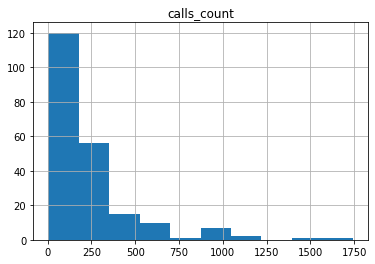

In [88]:
outgoing_effective[['calls_count']].hist()
plt.show()

In [89]:
# Looking at effective operators' calls distribution
outgoing_ineffective[['calls_count']].describe()

,calls_count
count,200.000000
mean,108.845000
std,171.235008
min,1.000000
25%,2.000000
50%,30.500000
75%,134.500000
max,984.000000


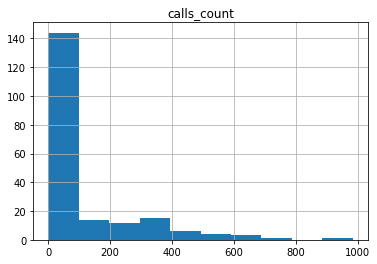

In [90]:
outgoing_ineffective[['calls_count']].hist()
plt.show()

### The data isn't distributed normally, so we'll use Mann-Whitney test

In [91]:
# Build samples
effective_calls = outgoing_effective['calls_count']
ineffective_calls = outgoing_ineffective['calls_count']

# General stats
print('Effective operators - Number of operators: {} | Average number of calls: {:.2f} | Std: {:.2f} \n'.format(
                                                                       effective_calls.count(),
                                                                       effective_calls.mean(),
                                                                       effective_calls.std()))

print('Ineffective operators - Number of operators: {} | Average number of calls: {:.2f} | Std: {:.2f} \n'.format(
                                                                       ineffective_calls.count(),
                                                                       ineffective_calls.mean(),
                                                                       ineffective_calls.std()))

alpha = 0.05
p_value = st.mannwhitneyu(effective_calls, ineffective_calls)[1]

print('P value is: {0:.5f} \n'.format(p_value))
if p_value < alpha:
    print('Null hypothesis is rejectd: There is a significant difference between the operators number of calls!')
else:
    print('Failed to reject the null hypothesis: We cannot say that there is a significant difference between the operators!')

Effective operators - Number of operators: 213 | Average number of calls: 229.13 | Std: 265.00 

Ineffective operators - Number of operators: 200 | Average number of calls: 108.84 | Std: 171.24 

P value is: 0.00000 

Null hypothesis is rejectd: There is a significant difference between the operators number of calls!


### Statistic  tests conclusion - there is a significant difference between the effective and the ineffective operators!

##  Setting data to Tableau

In [92]:
# Adding columns for united pattern
out_data_grouped['direction'] = 'out'
out_data_grouped['missed_calls'] = out_data_grouped['calls_count'] - out_data_grouped['succ_calls']
out_data_grouped['miss_perc'] = round(out_data_grouped['missed_calls'] / out_data_grouped['calls_count'] * 100 , 2)
out_data_grouped['avg_wait_duration'] = -1

# Define 'out' operators
out_tabl = out_data_grouped[['operator_id', 'direction', 'calls_count', 'succ_calls', 'missed_calls',  'succ_perc', 'miss_perc', 
             'avg_wait_duration', 'rank_group']]
out_tabl.head()

,operator_id,direction,calls_count,succ_calls,missed_calls,succ_perc,miss_perc,avg_wait_duration,rank_group
763,952466.0,out,42,1,41,2.38,97.62,-1,1
680,945284.0,out,335,1,334,0.30,99.70,-1,1
694,945318.0,out,332,1,331,0.30,99.70,-1,1
771,953458.0,out,38,1,37,2.63,97.37,-1,1
367,919482.0,out,76,1,75,1.32,98.68,-1,1


In [93]:
# Adding columns for united pattern
in_data_grouped['direction'] = 'in'
in_data_grouped['succ_perc'] = round(in_data_grouped['succ_calls'] / in_data_grouped['calls_count'] * 100 , 2)

# Define 'in' operators
in_tabl = in_data_grouped[['operator_id', 'direction', 'calls_count', 'succ_calls', 'missed_calls',
       'succ_perc', 'miss_perc', 'avg_wait_duration', 'rank_group']]
in_tabl.head()

,operator_id,direction,calls_count,succ_calls,missed_calls,succ_perc,miss_perc,avg_wait_duration,rank_group
678,954086.0,in,31,1,30,3.23,96.77,64.0,1
173,903974.0,in,10,2,8,20.00,80.00,83.5,1
118,898920.0,in,13,2,11,15.38,84.62,97.0,1
111,898414.0,in,24,2,22,8.33,91.67,126.0,1
12,882688.0,in,15,2,13,13.33,86.67,336.5,1


In [94]:
# Join the dataframes to one 
tableau = pd.concat([in_tabl, out_tabl], axis=0)
tableau = tableau.merge(data[['operator_id', 'tariff_plan']].drop_duplicates(), on='operator_id', how='inner'
                       ).query('rank_group in (1, 2, 3)')
tableau.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1630 entries, 0 to 1629
Data columns (total 10 columns):
operator_id          1630 non-null float64
direction            1630 non-null object
calls_count          1630 non-null int64
succ_calls           1630 non-null int64
missed_calls         1630 non-null int64
succ_perc            1630 non-null float64
miss_perc            1630 non-null float64
avg_wait_duration    1630 non-null float64
rank_group           1630 non-null int64
tariff_plan          1630 non-null category
dtypes: category(1), float64(4), int64(4), object(1)
memory usage: 129.0+ KB


In [95]:
# tableau.to_csv(r'C:\Users\ron\Desktop\final_project\operators.csv', index=False)
tableau.head()

,operator_id,direction,calls_count,succ_calls,missed_calls,succ_perc,miss_perc,avg_wait_duration,rank_group,tariff_plan
0,954086.0,in,31,1,30,3.23,96.77,64.0,1,C
1,954086.0,out,1,1,0,100.00,0.00,-1.0,2,C
2,903974.0,in,10,2,8,20.00,80.00,83.5,1,C
3,898920.0,in,13,2,11,15.38,84.62,97.0,1,B
4,898920.0,out,37,2,35,5.41,94.59,-1.0,1,B


## The end !
## Link to Presentation <a href="https://drive.google.com/file/d/1S6UsYyt30D7H4Lwqzy_HsxKT_BzJdir_/view?usp=sharing"> Here </a>
## Link to Tableau dashboard  <a href="https://public.tableau.com/profile/ron.sherwi#!/vizhome/OperatorsBehavior/Dashboard?publish=yes"> Here </a>